# Hyperparameter Optimization with Hyperopt



## Install Hyperopt package

In [1]:
!pip install hyperopt

## Import required libraries

In [29]:
import warnings
warnings.simplefilter('ignore')
from ludwig.api import LudwigModel
from ludwig.utils.data_utils import load_json
from ludwig.visualize import learning_curves
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import logging


In [155]:
model_definition = {
    'input_features': [
        {'name': 'Pclass', 'type': 'category'},
        {'name': 'Sex', 'type': 'category'},
        {'name': 'Age', 'type': 'numerical', 
            'preprocessing': {'missing_value_strategy': 'fill_with_mean', 'normalization': 'zscore'}},
        {'name': 'SibSp', 'type': 'numerical', 
            'preprocessing': {'missing_value_strategy': 'fill_with_mean', 'normalization': 'minmax'}},
        {'name': 'Parch', 'type': 'numerical',
            'preprocessing': {'missing_value_strategy': 'fill_with_mean', 'normalization': 'minmax'}},
        {'name': 'Fare', 'type': 'numerical',
            'preprocessing': {'missing_value_strategy': 'fill_with_mean', 'normalization': 'zscore'}},
        {'name': 'Embarked', 'type': 'category'}
    ],
    
    'output_features':[
        {'name': 'Survived', 'type': 'binary', 
            'fc_layers': [{'fc_size': 50}] }
    ],
    
    'training': {}
}

In [156]:
# clean out old results
try:
    shutil.rmtree('./results')
except:
    pass

try:
    shutil.rmtree('./visualizations')
except:
    pass

try:
    file_list = glob.glob('./data/*.json')
    file_list.append(glob.glob('./data/*.hdf5'))
    os.remove(file_list)
except:
    pass


In [157]:
raw_df = pd.read_csv('./data/train.csv')
raw_df.shape

(891, 12)

In [158]:
train_df, vald_df = train_test_split(raw_df, test_size = 0.2)

## Define objective function for minimization

In [172]:
def score_model(params):
    
    print(params)

    learning_rate = params['learning_rate']
    fc_size = np.int(params['fc_size'])
    
    model_definition['training']['learning_rate'] = learning_rate
    model_definition['output_features'][0]['fc_layers'][0]['fc_size'] = fc_size
    
    # Define Ludwig model object that drive model training
    model = LudwigModel(model_definition,
                        logging_level=logging.WARN)

    # initiate model training
    train_stats = model.train(data_train_df = train_df,
                            data_validation_df = vald_df,
                            experiment_name='experiment_name',
                            model_name='model_name',
                            skip_save_training_description=True, 
                            skip_save_training_statistics=True, 
                            skip_save_model=True, 
                            skip_save_progress=True,                          
                            skip_save_log=True,
                            skip_save_processed_input=True)



    model.close()
    
    validation_losses = train_stats['validation']['Survived']['loss']
    
    last_epoch = len(validation_losses)
    
    return {'loss': validation_losses[last_epoch - 1], 'status': STATUS_OK}

## Define hyperparameter space for optimization

In [173]:
space = {'learning_rate':  hp.uniform('learning_rate', 0.01, 0.0001),
         'output_fc_layers': hp.choice('output_fc_layers',[
             ['fc_size': hp.quniform('layer1',5,100,1)],
             [hp.quniform('layer1',5,100,1),]
         ])
        }

In [174]:
trials = Trials()

In [175]:
best = fmin(fn=score_model,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials)

{'fc_size': 30.0, 'learning_rate': 0.0005444781357765317}
{'fc_size': 24.0, 'learning_rate': 0.005649402747331224}                     
{'fc_size': 35.0, 'learning_rate': 0.00903287275892338}                       
{'fc_size': 32.0, 'learning_rate': 0.007947258501046106}                      
{'fc_size': 46.0, 'learning_rate': 0.007491975547789343}                      
{'fc_size': 24.0, 'learning_rate': 0.007251549703582612}                      
{'fc_size': 29.0, 'learning_rate': 0.008631880310088224}                      
{'fc_size': 47.0, 'learning_rate': 0.0036775439792056733}                   
{'fc_size': 29.0, 'learning_rate': 0.00535621197670413}                     
{'fc_size': 40.0, 'learning_rate': 0.009676681866499545}                    
{'fc_size': 40.0, 'learning_rate': 0.005353785778393563}                     
{'fc_size': 28.0, 'learning_rate': 0.00874195588421699}                      
{'fc_size': 44.0, 'learning_rate': 0.003975020005097009}                     
{'fc

In [177]:
[(trials.trials[i]['result'], trials.trials[i]['misc']['vals'])  for i in range(len(trials.trials))]

[({'loss': 0.4604251051748265, 'status': 'ok'},
  {'fc_size': [30.0], 'learning_rate': [0.0005444781357765317]}),
 ({'loss': 0.42951139524662296, 'status': 'ok'},
  {'fc_size': [24.0], 'learning_rate': [0.005649402747331224]}),
 ({'loss': 0.4398306095400336, 'status': 'ok'},
  {'fc_size': [35.0], 'learning_rate': [0.00903287275892338]}),
 ({'loss': 0.42868021746587487, 'status': 'ok'},
  {'fc_size': [32.0], 'learning_rate': [0.007947258501046106]}),
 ({'loss': 0.433350067564895, 'status': 'ok'},
  {'fc_size': [46.0], 'learning_rate': [0.007491975547789343]}),
 ({'loss': 0.428649891688171, 'status': 'ok'},
  {'fc_size': [24.0], 'learning_rate': [0.007251549703582612]}),
 ({'loss': 0.44137505046482195, 'status': 'ok'},
  {'fc_size': [29.0], 'learning_rate': [0.008631880310088224]}),
 ({'loss': 0.4383517323925508, 'status': 'ok'},
  {'fc_size': [47.0], 'learning_rate': [0.0036775439792056733]}),
 ({'loss': 0.438923137813973, 'status': 'ok'},
  {'fc_size': [29.0], 'learning_rate': [0.00535

In [178]:
best

{'fc_size': 24.0, 'learning_rate': 0.007251549703582612}

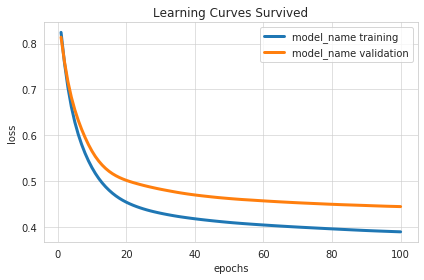

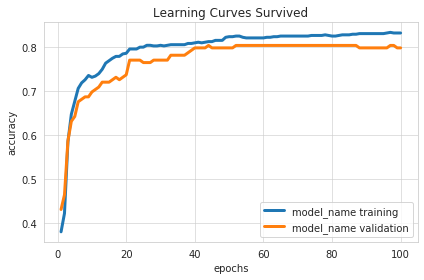

In [51]:
# generating learning curves from training
learning_curves(trs, 'Survived',
                model_names=['model_name'],
                output_directory='./visualizations',
                file_format='png')

In [101]:
from hyperopt import fmin, tpe, hp, Trials
trials = Trials()
best = fmin(fn=lambda x: x ** 2,
    space=hp.uniform('x', -10, 10),
    algo=tpe.suggest,
    max_evals=20,
    trials=trials)
print(best)

100%|██████████| 20/20 [00:00<00:00, 896.02it/s, best loss: 0.38466882450765444]
{'x': -0.620216756068114}


In [102]:
best

{'x': -0.620216756068114}

In [103]:
trials

In [104]:
[(trials.trials[i]['result'], trials.trials[i]['misc']['vals'])  for i in range(len(trials.trials))]

[({'loss': 21.29482988255073, 'status': 'ok'}, {'x': [4.614632150296568]}),
 ({'loss': 88.42113174031475, 'status': 'ok'}, {'x': [-9.403251126090101]}),
 ({'loss': 80.58822978508573, 'status': 'ok'}, {'x': [-8.977094729648659]}),
 ({'loss': 56.89454378542909, 'status': 'ok'}, {'x': [7.542847193562196]}),
 ({'loss': 12.578645357887456, 'status': 'ok'}, {'x': [-3.546638599841751]}),
 ({'loss': 51.310397436710794, 'status': 'ok'}, {'x': [-7.163127629514275]}),
 ({'loss': 0.38466882450765444, 'status': 'ok'}, {'x': [-0.620216756068114]}),
 ({'loss': 2.6241423512844078, 'status': 'ok'}, {'x': [1.6199204768396527]}),
 ({'loss': 73.9022854834035, 'status': 'ok'}, {'x': [8.596643849980264]}),
 ({'loss': 0.39014245376631607, 'status': 'ok'}, {'x': [-0.6246138437197146]}),
 ({'loss': 81.22242886825498, 'status': 'ok'}, {'x': [9.012348687675981]}),
 ({'loss': 23.432074915599713, 'status': 'ok'}, {'x': [-4.840668850024727]}),
 ({'loss': 1.7936623335730666, 'status': 'ok'}, {'x': [-1.33927679498043

In [92]:
trials.trials[0]

{'state': 2,
 'tid': 0,
 'spec': None,
 'result': {'loss': 19.595287947517047, 'status': 'ok'},
 'misc': {'tid': 0,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'x': [0]},
  'vals': {'x': [4.4266565201647445]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2019, 12, 14, 20, 19, 58, 755000),
 'refresh_time': datetime.datetime(2019, 12, 14, 20, 19, 58, 755000)}

In [137]:
space = {'learning_rate':  hp.uniform('learning_rate', -10, 10)}

In [144]:
def score(params):
    x = np.float(params['learning_rate'])
    y = x ** 2
    
    return {'loss': y, 'status': STATUS_OK}

In [145]:
best = fmin(fn=score,
    space=space,
    algo=tpe.suggest,
    max_evals=20)

100%|██████████| 20/20 [00:00<00:00, 793.06it/s, best loss: 0.09893986028245308]


In [146]:
best

{'learning_rate': 0.3145470716481924}